In [17]:
import os
os.getcwd()

'/notebooks/code/self_deblur_replication'

In [18]:
from utils import layers
from utils import non_local_dot_product as block
import torch.nn as nn
import torch

In [3]:
class Swish(nn.Module):
    """
        https://arxiv.org/abs/1710.05941
        The hype was so huge that I could not help but try it
    """
    def __init__(self):
        super(Swish, self).__init__()
        self.s = nn.Sigmoid()

    def forward(self, x):
        return x * self.s(x)


def act(act_fun = 'LeakyReLU'):
    '''
        Either string defining an activation function or module (e.g. nn.ReLU)
    '''
    if isinstance(act_fun, str):
        if act_fun == 'LeakyReLU':
            return nn.LeakyReLU(0.2, inplace=True)
        elif act_fun == 'Swish':
            return Swish()
        elif act_fun == 'ELU':
            return nn.ELU()
        elif act_fun == 'none':
            return nn.Sequential()
        else:
            assert False
    else:
        return act_fun()

In [4]:
class Concat(nn.Module):
    def __init__(self, dim, *args):
        super(Concat, self).__init__()
        self.dim = dim

        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, input):
        inputs = []
        for module in self._modules.values():
            inputs.append(module(input))

        inputs_shapes2 = [x.shape[2] for x in inputs]
        inputs_shapes3 = [x.shape[3] for x in inputs]        

        if np.all(np.array(inputs_shapes2) == min(inputs_shapes2)) and np.all(np.array(inputs_shapes3) == min(inputs_shapes3)):
            inputs_ = inputs
        else:
            target_shape2 = min(inputs_shapes2)
            target_shape3 = min(inputs_shapes3)

            inputs_ = []
            for inp in inputs: 
                diff2 = (inp.size(2) - target_shape2) // 2 
                diff3 = (inp.size(3) - target_shape3) // 2 
                inputs_.append(inp[:, :, diff2: diff2 + target_shape2, diff3:diff3 + target_shape3])

        return torch.cat(inputs_, dim=self.dim)

In [5]:
class Skip(nn.Module):
    """
    Construct a unet like model with skip connections
    """
    def __init__(
        self,
        num_input_channels=2,
        num_output_channels=3,
        num_channels_down=[16, 32, 64, 128, 128],
        num_channels_up=[16, 32, 64, 128, 128],
        num_channels_skip=[4, 4, 4, 4, 4],
        filter_size_down=3,
        filter_size_up=3,
        filter_skip_size=1,
        need_sigmoid=True,
        need_bias=True,
        pad="zero",
        upsample_mode="nearest",
        downsample_mode="stride",
        act_fun="LeakyReLU",
        need1x1_up=True,
    ):
        super(Skip, self).__init__()
        self.num_input_channels = num_input_channels
        self.num_output_channels = num_output_channels
        self.num_channels_down = num_channels_down
        self.num_channels_up = num_channels_up
        self.num_channels_skip = num_channels_skip
        self.filter_size_up = filter_size_up
        self.filter_size_down = filter_size_down
        self.filter_skip_size = filter_skip_size
        self.need_sigmoid = need_sigmoid
        self.need_bias = need_bias
        self.pad = pad
        self.upsample_mode = upsample_mode
        self.downsample_mode = downsample_mode
        self.act_fun = act_fun
        self.need1x1_up = need1x1_up

    def single_skip(self,
                    in_channels,
                    num_channels_skip,
                    filter_skip_size,
                    pad,
                    bias=True):
        """
        implement a skip module:
        receive N,C,H,W output N,Ck,H,W with filter size as filter_skip_size, padding method as pad
        """
        skip = nn.Sequential()
        padder = None
        downsampler = None
        # convolution module to decrease channels
        ## padding size for conv2d
        to_pad = int((filter_skip_size - 1) / 2)
        ## choosing path method : zero or flection
        if pad == "reflection":
            padder = nn.ReflectionPad2d(to_pad)
            to_pad = 0
        ## constructing conv2d
        conv2d = nn.Conv2d(
            in_channels,
            num_channels_skip,
            filter_skip_size,
            1,
            padding=to_pad,
            bias=bias,
        )
        ## leave only non -None layers
        layers = filter(lambda x: x is not None, [padder, conv2d, downsampler])
        ## downsampler if neccessary

        skip.add_module("Skip_conv", nn.Sequential(*layers))

        # adding bn and activation
        skip.add_module("Skip_BN", nn.BatchNorm2d(num_channels_skip))
        skip.add_module("Leaky_RELU", act(act_fun="LeakyReLU"))

        return skip

    def deeper_before_concat(
        self,
        in_channels,
        num_channels_down,
        filter_down_size,
        stride,
        pad,
        downsampler,
        bias,
        act_fun,
        non_local
    ):
        """
        con_block -> bn -> leaky relu -> nonlocal2D block ->...
        purpose : reduce spatial dimension while increasing depth / num of channels

        """
        before_concat = []
        ## append conv : first block stride = 2 to reduce spatial dimensions
        before_concat.append(
            layers.conv(
                in_channels,
                num_channels_down,
                filter_down_size,
                stride=2,
                bias=bias,
                pad=pad,
                downsample_mode=downsampler,
            ))

        before_concat.append(nn.BatchNorm2d(num_channels_down))
        before_concat.append(layers.act(act_fun))
        if (non_local):
            before_concat.append(
                block.NONLocalBlock2D(in_channels=num_channels_down))
        
        before_concat.append(
            layers.conv(
                num_channels_down,
                num_channels_down,
                filter_down_size,
                bias=bias,
                pad=pad,
            ))
        before_concat.append(nn.BatchNorm2d(num_channels_down))
        before_concat.append(act(act_fun))
        return nn.Sequential(*before_concat)

    def construct(self):
        # self.model = nn.Sequential()
        # construct a model from input
        # construct encoder part, skip connection and post processing after each module
        
        depth = len(self.num_channels_down)
        # useful for debug later
        assert len(self.num_channels_up) == len(self.num_channels_down)
        assert len(self.num_channels_down) == len(self.num_channels_skip)
        assert len(self.num_channels_down) > 0
        ### build a unet like module
        encoder = [None]* depth
        skip = [None]* depth
        post = [None]* depth
        decoder = [None] * depth
        non_local = False
        ### create module
        for i in range(depth):
            if (i == 0):
                in_channels = self.num_input_channels
                non_local = False
            else:
                in_channels = self.num_channels_down[i - 1]
                if (i>1):
                    non_local = True
            encoder[i] = self.deeper_before_concat(in_channels,
                                                   self.num_channels_down[i],
                                                   self.filter_size_down,
                                                   1, self.pad,
                                                   self.downsample_mode, self.need_bias,
                                                   self.act_fun,non_local)
            skip[i] = self.single_skip(in_channels, self.num_channels_skip[i],
                                       self.filter_skip_size, self.pad,
                                       self.need_bias)
            post[i] = self.post_processing(self.num_channels_down[i]+self.num_channels_skip[i],self.num_channels_up[i],self.filter_size_up)
            # decoder[i] = nn.Sequential(torch.cat(skip[5-i],))
        
        
        
        return encoder, skip,post
    
    def post_processing(self,input_channel,output_channel,kernel_size):
        """
        return post_processing layers
        input channel : num of channels for coming input
        output channel: desired number of channels
        """
        bn = []
        bn.append(nn.BatchNorm2d(input_channel))
        bn.append(layers.conv(input_channel, output_channel, kernel_size, bias=self.need_bias, pad=self.pad))
        bn.append(nn.BatchNorm2d(output_channel))
        bn.append(act(self.act_fun))
        bn.append(layers.conv(output_channel, output_channel, 1, bias=self.need_bias, pad=self.pad))
        bn.append(nn.BatchNorm2d(output_channel))
        bn.append(act(self.act_fun))
        return bn
        
        
    def model_tail(self):
        """
        construct the tail of model
        """
        tail = []
        input_channel = self.num_channels_up[0]
        output_channel = self.num_output_channels
        kernel_size = 1

        tail.append(layers.conv(input_channel, output_channel, kernel_size, bias=self.need_bias, pad=self.pad))
        tail.append(nn.Sigmoid())
        return tail

    def forward(self, input):
        return None



In [6]:
demo =  Skip(num_input_channels=8,
        num_output_channels=1,
         num_channels_down = [128, 128, 128, 128, 128],
        num_channels_up   = [128, 128, 128, 128, 128],
        num_channels_skip = [16, 16, 16, 16, 16],
        filter_size_down=3,
        filter_size_up=3,
        filter_skip_size=1,
        need_sigmoid=True,
        need_bias=True,
        pad="reflection",
        upsample_mode="nearest",
        downsample_mode="stride",
        act_fun="LeakyReLU",
        need1x1_up=True)
device = torch.device('cuda:0')
demo = demo.to(device)
e,s,p = demo.construct()
print(len(e))

5


In [7]:
from torchinfo import summary

In [ ]:
summary(s[0],(1,8,320,505))

In [8]:
import numpy as np

e[4].add_module("upsampling_2",nn.Upsample(scale_factor=2, mode="nearest"))

deeper = nn.Sequential(Concat(1,s[4],e[4]))
## add post-process layers
for i in p[4]:
    deeper.add(i)
e[3].add_module("deeper_3",deeper)
## add upsampling
e[3].add_module("upsampling_2",nn.Upsample(scale_factor=2, mode="nearest"))

model = None
deeper = nn.Sequential(Concat(1,s[3],e[3]))
## add post-process layers
for i in p[3]:
    deeper.add(i)
e[2].add_module("deeper_3",deeper)
e[2].add_module("upsampling_2",nn.Upsample(scale_factor=2, mode="nearest"))

deeper = nn.Sequential(Concat(1,s[2],e[2]))
## add post-process layers
for i in p[2]:
    deeper.add(i)
e[1].add_module("deeper_3",deeper)
e[1].add_module("upsampling_2",nn.Upsample(scale_factor=2, mode="nearest"))

deeper = nn.Sequential(Concat(1,s[1],e[1]))
## add post-process layers
for i in p[1]:
    deeper.add(i)
e[0].add_module("deeper_2",deeper)
e[0].add_module("upsampling_1",nn.Upsample(scale_factor=2, mode="nearest"))

model = nn.Sequential(Concat(1,s[0],e[0]))
## add post-process layers
for i in p[0]:
    model.add(i)

for i in (demo.model_tail()):
    print(i)
    model.add(i)
# ref.add_module("deeper_depth_2",deeper)

print(summary(model,(1,8,1278,2020),depth=15))

Sequential(
  (0): ReflectionPad2d((0, 0, 0, 0))
  (1): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
)
Sigmoid()
Layer (type:depth-idx)                                                                                    Output Shape              Param #
Sequential                                                                                                --                        --
├─Concat: 1-1                                                                                             [1, 144, 1278, 2020]      --
│    └─Sequential: 2-1                                                                                    [1, 16, 1278, 2020]       --
│    │    └─Sequential: 3-1                                                                               [1, 16, 1278, 2020]       --
│    │    │    └─ReflectionPad2d: 4-1                                                                     [1, 8, 1278, 2020]        --
│    │    │    └─Conv2d: 4-2                                       

In [ ]:
# import numpy as np

# e[4].add_module("upsampling_2",nn.Upsample(scale_factor=2, mode="nearest"))

# deeper = nn.Sequential(Concat(1,s[4],e[4]))
# ## add post-process layers
# for i in p[4]:
#     deeper.add(i)
# e[3].add_module("deeper_3",deeper)
# ## add upsampling
# e[3].add_module("upsampling_2",nn.Upsample(scale_factor=2, mode="nearest"))


# model = None
# deeper = nn.Sequential(Concat(1,s[3],e[3]))
# ## add post-process layers
# for i in p[3]:
#     deeper.add(i)
# e[2].add_module("deeper_3",deeper)
# e[2].add_module("upsampling_2",nn.Upsample(scale_factor=2, mode="nearest"))

# deeper = nn.Sequential(Concat(1,s[2],e[2]))
# e[1].add_module("deeper_3",deeper)
# e[1].add_module("upsampling_2",nn.Upsample(scale_factor=2, mode="nearest"))

# deeper = nn.Sequential(Concat(1,s[1],e[1]))
# e[0].add_module("deeper_2",deeper)
# e[0].add_module("upsampling_1",nn.Upsample(scale_factor=2, mode="nearest"))

# model = nn.Sequential(Concat(1,s[0],e[0]))


# for i in (demo.model_tail()):
#     print(i)
#     model.add(i)
# # ref.add_module("deeper_depth_2",deeper)

# print(summary(model,(1,8,1278,2020),depth=15))

In [ ]:
!nvidia-smi

In [ ]:
len(demo.model_tail())

In [7]:
os.getcwd()

'/notebooks/code/SelfDeblur'

In [2]:
import os
os.chdir("../SelfDeblur")

In [20]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [4]:
!python selfdeblur_levin.py --num_iter 1000 --data_path ../levin_set/groundtruth --save_path ../result_levin_2

../levin_set/groundtruth/im1_kernel1_img.png
im1_kernel1_img
k shape:  torch.Size([200])
1d w torch.Size([11, 1])
y tensor([[[[0.6706, 0.6902, 0.6941,  ..., 0.0745, 0.0784, 0.0902],
          [0.6627, 0.6902, 0.6863,  ..., 0.0784, 0.0824, 0.0941],
          [0.6431, 0.6784, 0.6667,  ..., 0.0745, 0.0863, 0.0980],
          ...,
          [0.0392, 0.0510, 0.0902,  ..., 0.0431, 0.0510, 0.0510],
          [0.0431, 0.0510, 0.0902,  ..., 0.0510, 0.0471, 0.0471],
          [0.0431, 0.0510, 0.0980,  ..., 0.0510, 0.0471, 0.0431]]]],
       device='cuda:0')
  0%|                                                  | 0/1000 [00:00<?, ?it/s]tensor(0.1030, device='cuda:0', grad_fn=<MseLossBackward>)
tensor([0.0496, 0.0768, 0.0088, 0.0132, 0.0307, 0.0634, 0.0490, 0.0896, 0.0456,
        0.0632, 0.0349, 0.0402, 0.0022, 0.0169, 0.0294, 0.0519, 0.0698, 0.0800,
        0.0161, 0.0282, 0.0682, 0.0915, 0.0397, 0.0874, 0.0419, 0.0553, 0.0953,
        0.0036, 0.0185, 0.0373, 0.0305, 0.0932, 0.0176, 0.0270, 0.0

In [13]:
!python selfdeblur_nonblind.py --num_iter 1000 --data_path ../levin_set/groundtruth --save_path ./results/levin

im1
100%|███████████████████████████████████████| 1000/1000 [01:13<00:00, 13.63it/s]
im1_kernel1_img
100%|███████████████████████████████████████| 1000/1000 [01:09<00:00, 14.32it/s]
im1_kernel2_img
100%|███████████████████████████████████████| 1000/1000 [01:08<00:00, 14.56it/s]
im1_kernel3_img
100%|███████████████████████████████████████| 1000/1000 [01:07<00:00, 14.92it/s]
im1_kernel4_img
100%|███████████████████████████████████████| 1000/1000 [01:13<00:00, 13.64it/s]
im1_kernel5_img
100%|███████████████████████████████████████| 1000/1000 [01:07<00:00, 14.90it/s]
im1_kernel6_img
100%|███████████████████████████████████████| 1000/1000 [01:11<00:00, 14.00it/s]
im1_kernel7_img
100%|███████████████████████████████████████| 1000/1000 [01:11<00:00, 14.03it/s]
im1_kernel8_img
100%|███████████████████████████████████████| 1000/1000 [01:11<00:00, 14.02it/s]
im2
100%|███████████████████████████████████████| 1000/1000 [01:11<00:00, 14.00it/s]
im2_kernel1_img
100%|█████████████████████████████████

In [2]:
import os
os.getcwd()

'/notebooks/code/self_deblur_replication'

In [20]:
os.chdir('../self_deblur_replication')

In [3]:
!python run.py

reading image :  ../levin_set/groundtruth/im3_kernel8_img.png
gray scale image
image size:  (255, 255)
torch.Size([1, 1, 255, 255])
noise x shape:  torch.Size([1, 8, 275, 275])
noise k shape:  torch.Size([200])
Sequential(
  (Linear_first): Linear(in_features=200, out_features=256, bias=True)
  (activation): ReLU6()
  (Probability linear): Linear(in_features=256, out_features=441, bias=True)
  (prob activation): Softmax(dim=None)
)
*****************************
0it [00:00, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
10it [00:39,  3.90s/it]
average loss:  0.3821801729500294
Figure(640x480)


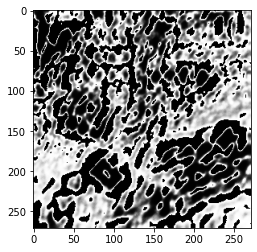

In [5]:
import cv2
from matplotlib import pyplot as plt
a = cv2.imread("im1_kernel1_img.png")
plt.imshow(a*255)

In [14]:
a*255

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]